# Notebook for analysing all VR trials of one experimental group; 2-object forest
## Assumes use of FlyOver version 9.7 or higher (closed-loop optogenetic stimulation possible)
## Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [370]:
__author__ = 'Hannah Haberkern, hjmhaberkern@gmail.com'

import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/flyVRoptogenetics/')
from flyVRoptogenetics_oneTrialBasicAnalysis import singleTwoObjVROptogenTrialAnalysis

path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import makeNestedPlotDirectory, myAxisTheme
from objectInteractionPlots import residencyWithHistograms_splitOnWalking, residencyWithHistograms,\
        radDistAngleCombiPlot, plotResidencyInMiniarena, make4ValuePolCoordPlot

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from trajectoryDerivedParams import relationToObject, cartesian2polar, polarCurvature
from plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df, plotVeloHeadingDistribution2_flyVR_df,\
                               oneDimResidency_df, turnRatePerDistance

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import rZoneParamsFromLogFile

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjectOptogen/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01-5', 'm02-5', 'm03-5', 'm04-5', 'm05-5', 'm06-5', 'm07-5', 'm08-5', 'm09-5', 'mf01-5', 'mf02-5', 'mf03-5', 'mf04-5', 'mf05-5', 'mf06-5']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [372]:
expDirs=expDirs[:9]
expDirs

['m01-5',
 'm02-5',
 'm03-5',
 'm04-5',
 'm05-5',
 'm06-5',
 'm07-5',
 'm08-5',
 'm09-5']

In [13]:
from operator import itemgetter
my_indices = [7,8,9,10]#[0,2,4,6,7,8,9,10,11,12]
expDirs = itemgetter(*my_indices)(expDirs)

### Compose mutli-fly data into dataframe

In [373]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [374]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [375]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','starvation','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

nTrialsPr = 0
nTrialsTr = 0
nTrialsPo = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[6]
        starvation = fileToAnalyse.split('_')[5]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if '-5' in currExpDir:
            if '_fm' in FODataFiles or '_ff' in FODataFiles:
                genotype = 'fed-500ms'
            else:
                genotype = 'starved-500ms'
        else:
            if '_fm' in FODataFiles or '_ff' in FODataFiles:
                genotype = 'fed-200ms'
            else:
                genotype = 'starved-200ms'
        
        if rerunbasicanalysis == 'y':
            returnVal = singleTwoObjVROptogenTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
            nTrialsTr += 1
        elif 'pre' in fileToAnalyse:
            trialtype = 'pre'
            rZones = 'off'
            nTrialsPr += 1
        else:
            trialtype = 'post'
            rZones = 'off'
            nTrialsPo += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'starvation', int(starvation[:-1]))
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjectOptogen/Gr43a-TM3_x_10ChrimsonR/500ms/male/rawData/m01-5/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_8d_12h_m01-5_post_out_161018102627.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_8d_12h_m01-5_pre_out_161018095431.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_8d_12h_m01-5_train_out_161018100549.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjectOptogen/Gr43a-TM3_x_10ChrimsonR/500ms/male/rawData/m02-5/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_8d_12h_m02-5_post_out_161018110945.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_8d_12h_m02-5_pre_out_161018103901.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_8d

In [376]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,reinforcement,starvation,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,m01-5,1,post,off,12,1,-0.000004,2.906013,0.000000,12.313395,60.622000,60.622000,35.000000,35.000000,0
1,m01-5,1,post,off,12,1,0.145310,3.769431,0.050004,8.008302,61.223100,61.223100,35.133400,35.133400,0
2,m01-5,1,post,off,12,1,0.333798,2.434517,0.100009,6.109464,61.598913,61.598913,35.271696,35.271696,0
3,m01-5,1,post,off,12,1,0.455535,1.806281,0.150013,12.884399,61.878600,61.878600,35.394600,35.394600,0
4,m01-5,1,post,off,12,1,0.545857,1.492084,0.200018,9.260780,62.424408,62.424408,35.736925,35.736925,0
5,m01-5,1,post,off,12,1,0.620468,1.492372,0.250022,13.534030,62.791641,62.791641,36.019030,36.019030,0
6,m01-5,1,post,off,12,1,0.695093,1.413551,0.300027,9.586621,63.321300,63.321300,36.440300,36.440300,0
7,m01-5,1,post,off,12,1,0.765777,1.413630,0.350031,6.910095,63.574900,63.574900,36.847100,36.847100,0
8,m01-5,1,post,off,12,1,0.836465,1.492281,0.400036,3.906766,63.753000,63.753000,37.143200,37.143200,0
9,m01-5,1,post,off,12,1,0.911085,1.570709,0.450040,6.968202,63.713400,63.713400,37.334500,37.334500,0


In [377]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [378]:
# Two object reinforcement test
rZoneState = ['off','on','off']
visibilityState = ['visible','visible','visible']
groundPlane = ['texture','texture','texture']
trialName = ['pre','train','post']
gridSize = 60.0

coneColor = 'darkred'
cyliColor = 'black'

#rZone_rInner, rZone_rOuter, rZone_max, rZone_gExp = rZoneParamsFromLogFile(expDir, fileToAnalyse)

In [379]:
%matplotlib inline 

### Trajectory plots of all trials

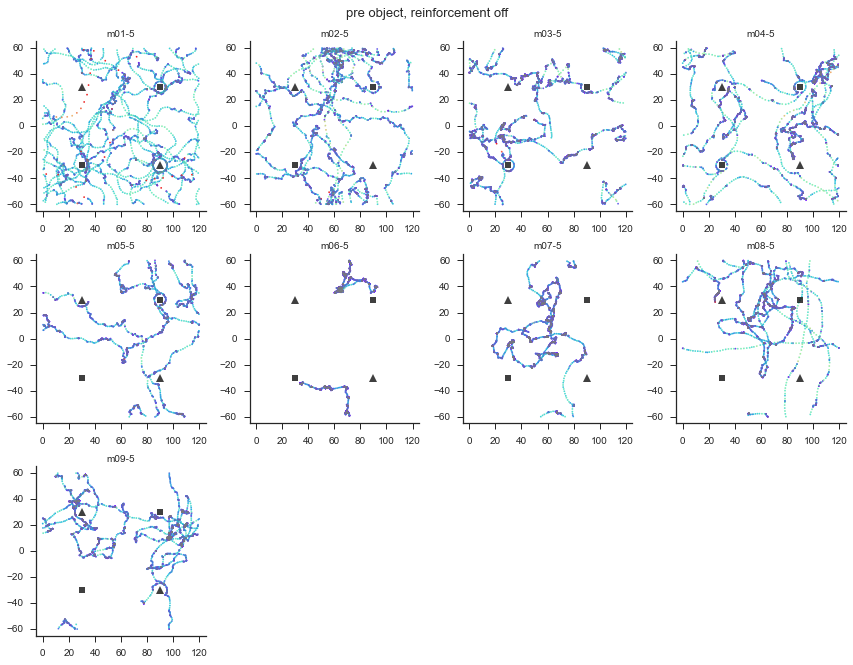

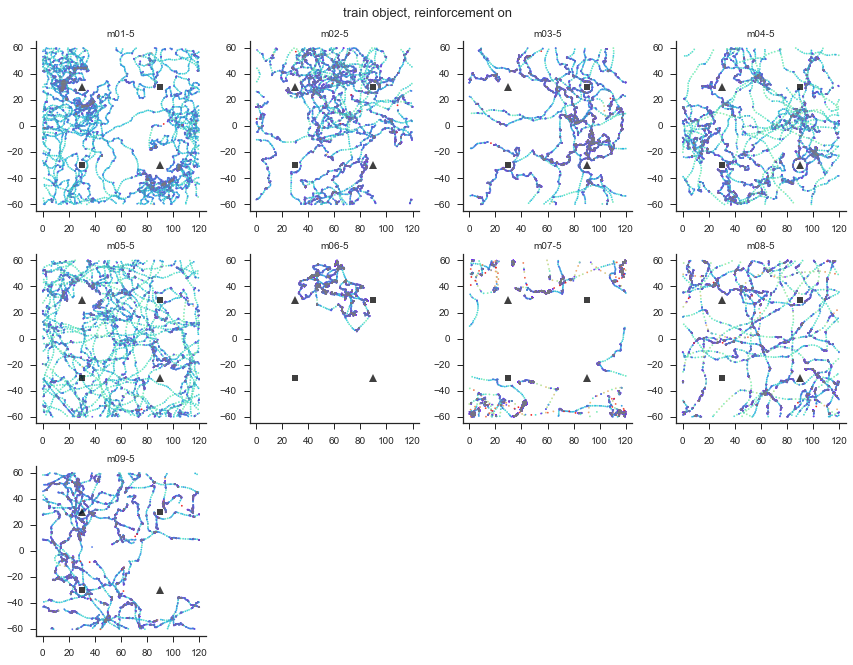

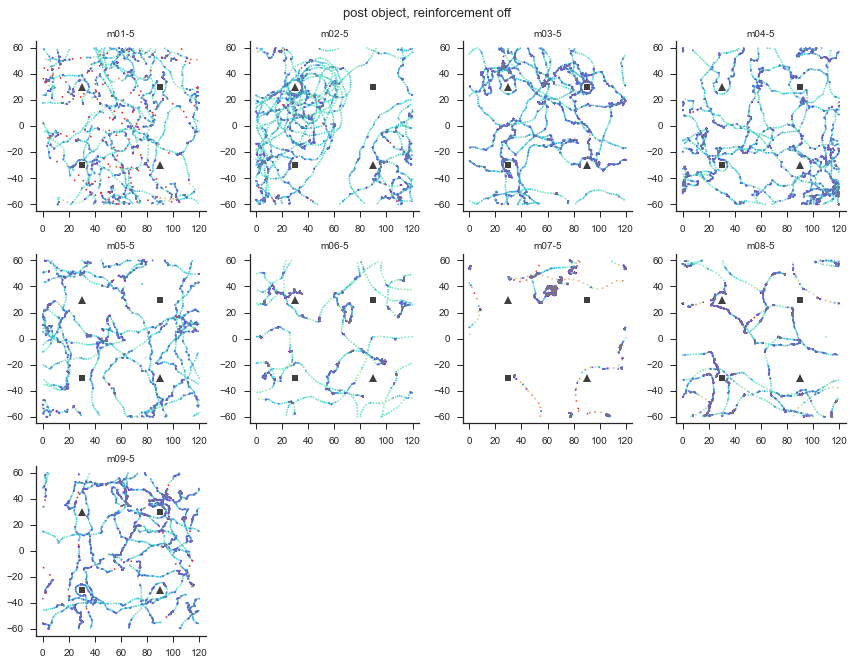

In [380]:
nrows = np.ceil(numFlies/4.0)
for ttind,trialtype in enumerate(trialName):
    multiflyTracePlot = plt.figure(figsize=(12,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' object, reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].values.squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
        
        selectPts = range(0,len(perFlyX),3)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        if (visibilityState[ttind] == 'visible'):
            multiflyTracePlot_sbplt.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.75, color='black')
        else:
            multiflyTracePlot_sbplt.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=cyliColor)
            multiflyTracePlot_sbplt.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=coneColor)
            multiflyTracePlot_sbplt.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=coneColor)
            multiflyTracePlot_sbplt.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=cyliColor)
        #if(rZoneState[ttind]=='on'):
        #    rZoneRange = float(rZone_rOuter - rZone_rInner)
        #    for zRad in range(rZone_rInner, rZone_rOuter):
        #        circle1 = plt.Circle((0, 0), zRad, color='r', alpha=1.0/rZoneRange)
        #        multiflyTracePlot_sbplt.add_artist(circle1)
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-5, gridSize*2 + 5)
        multiflyTracePlot_sbplt.set_ylim(-5-gridSize, gridSize + 5)
        
    multiflyTracePlot.tight_layout()
    
    # analysisDir + 'tracePlotMA/' should already exist from single trial analysis
    # makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', objecttype + sep)
    multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype +'_trial'+ rZoneState[ttind]
                              +'_traceVeloColored_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Effect of reinforcement on walking velocity

Plot directory already exists


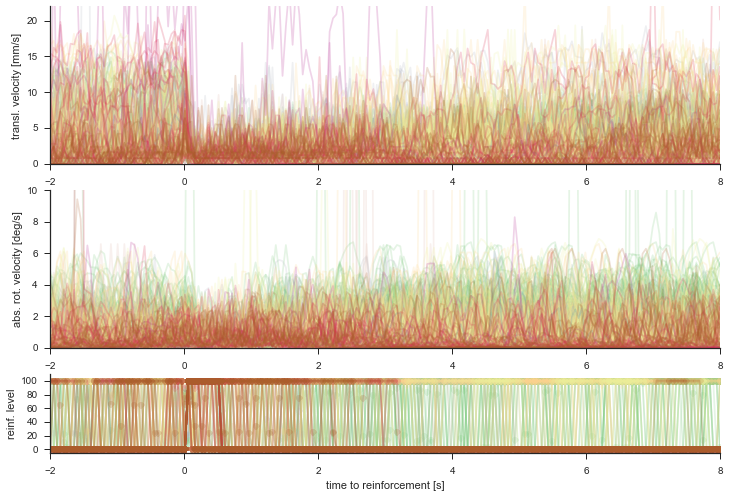

In [381]:
trialtype ='train'

fps = 20.0
 
rewardEffectFig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3,1,height_ratios=[1,1,0.5])

rewardVTPlt = rewardEffectFig.add_subplot(gs[0])
rewardVRPlt = rewardEffectFig.add_subplot(gs[1])
rewardEVPlt = rewardEffectFig.add_subplot(gs[2])
    
for fly in range(numFlies):
    flyCol = flyCMap.to_rgba(fly)
    querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

    perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].values.squeeze()
    perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].values.squeeze()
    perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
    perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
    perFlyEv = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

    evTimes = np.where(perFlyEv>80)[0]
    evStarts = np.where(np.diff(perFlyEv)>0)[0]

    postWindow = 160
    preWindow = 40
    timeLine = np.linspace(-preWindow*1/fps,postWindow*1/fps,preWindow+postWindow)
    for evStart in evStarts:
        evStart = evStart
        if (evStart+postWindow > len(perFlyvT)):
            continue
        rewardVTPlt.plot(timeLine,perFlyvT[evStart-preWindow:evStart+postWindow],color=flyCol,alpha=0.2)
        rewardVRPlt.plot(timeLine,abs(perFlyvR[evStart-preWindow:evStart+postWindow]),color=flyCol,alpha=0.2)
        rewardEVPlt.plot(timeLine,perFlyEv[evStart-preWindow:evStart+postWindow],'o-',color=flyCol,alpha=0.2)

rewardVTPlt.set_ylim(0,22)
rewardVTPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardVTPlt.set_ylabel('transl. velocity [mm/s]')
myAxisTheme(rewardVTPlt)

rewardVRPlt.set_ylim(0,10)
rewardVRPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardVRPlt.set_ylabel('abs. rot. velocity [deg/s]')
myAxisTheme(rewardVRPlt)

rewardEVPlt.set_ylim(-5,110)
rewardEVPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardEVPlt.set_ylabel('reinf. level')
rewardEVPlt.set_xlabel('time to reinforcement [s]')
myAxisTheme(rewardEVPlt)


try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
rewardEffectFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                   +'_velocityRespToReinf_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

##Visit count

In [401]:
def countvisits(dist2Obj,visitRad):
    # count visits
    inside = (dist2Obj<visitRad).astype('int')
    time = np.linspace(0,600,len(dist2Obj))

    entries = np.zeros(len(inside))
    entries[1:] = np.diff(inside) == 1

    exits = np.zeros(len(inside))
    exits[1:] = np.diff(inside) == -1

    entryTime = time[entries.astype('bool')]
    exitTime = time[exits.astype('bool')]
    if len(entryTime) != len(exitTime):
        visitT = exitTime[0:min(sum(exits),sum(entries))] - entryTime[0:min(sum(exits),sum(entries))]
    else:
        visitT = exitTime - entryTime
        
    return entries, exits, visitT,entryTime,exitTime

Plot directory already exists
Plot directory already exists
Plot directory already exists
Plot directory already exists
Plot directory already exists
no cone visits detected
Plot directory already exists
no cone visits detected
no cylinder visits detected
Plot directory already exists
Plot directory already exists
Plot directory already exists


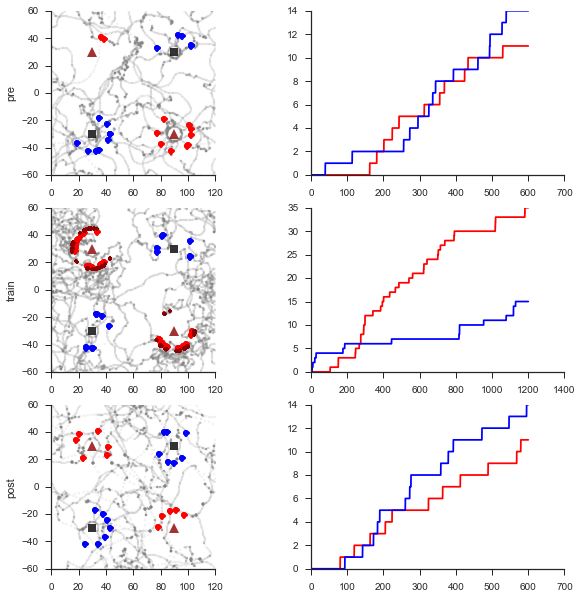

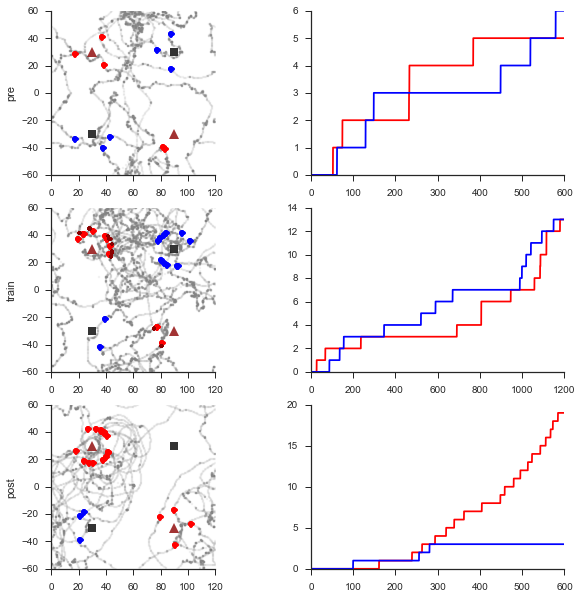

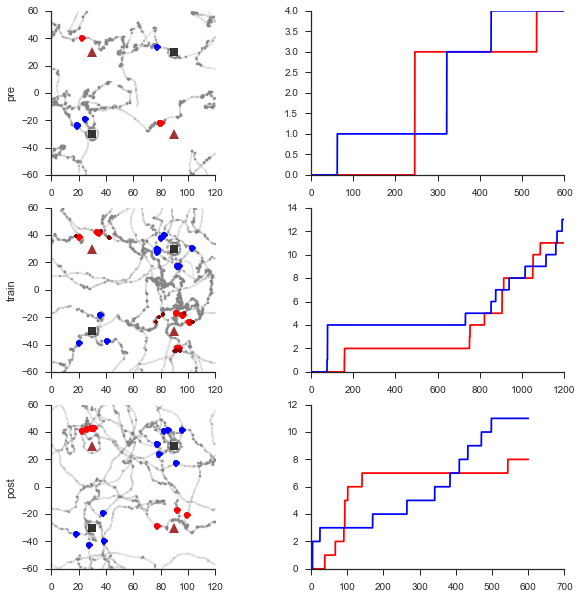

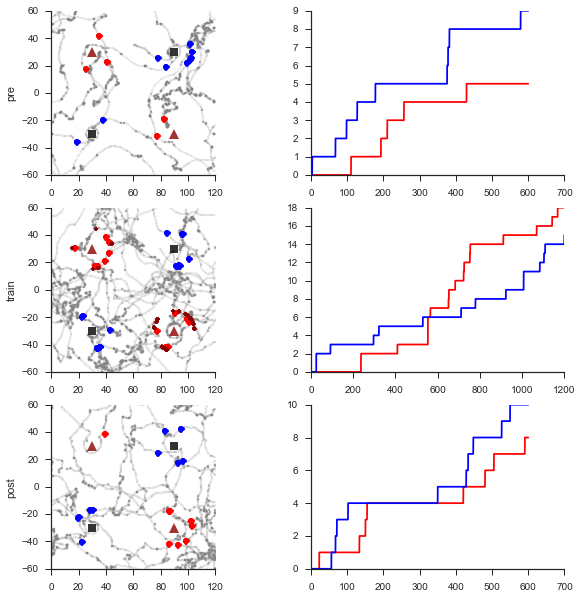

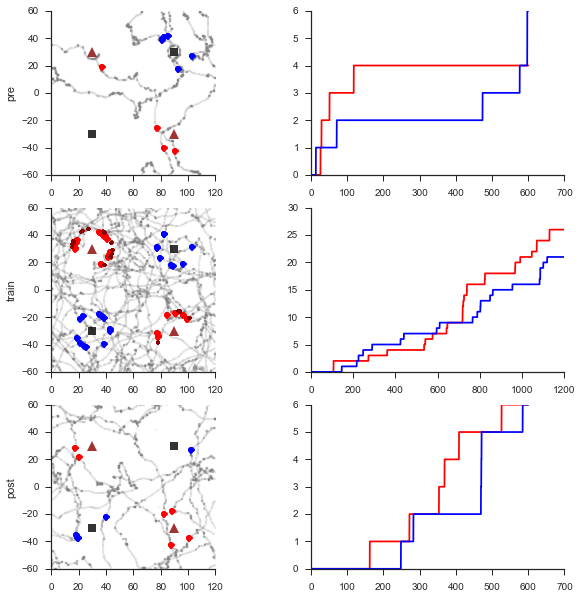

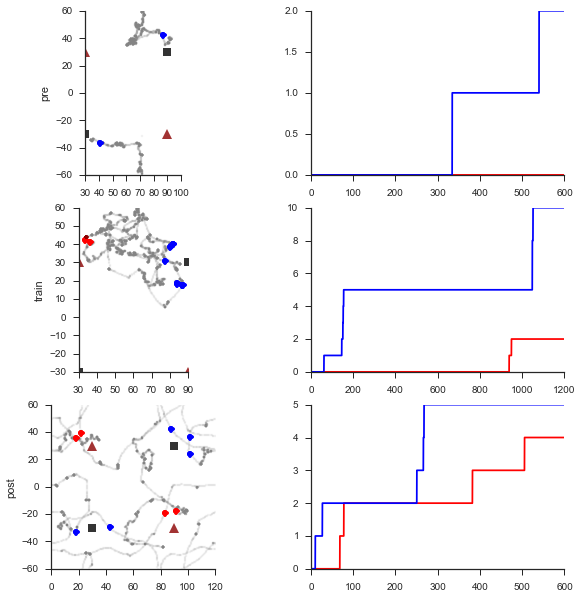

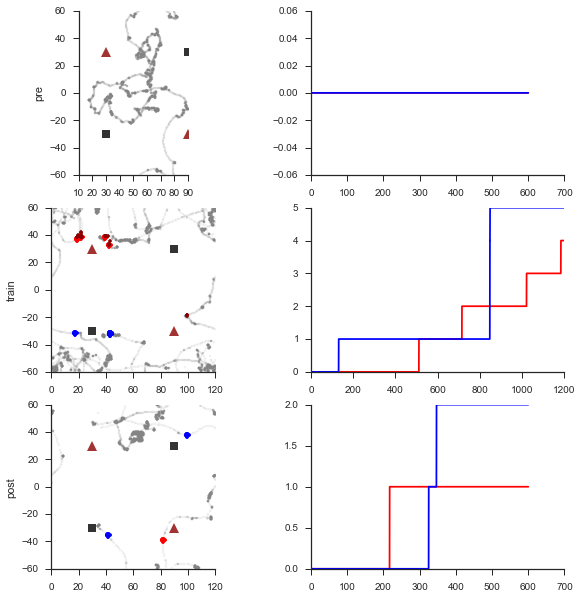

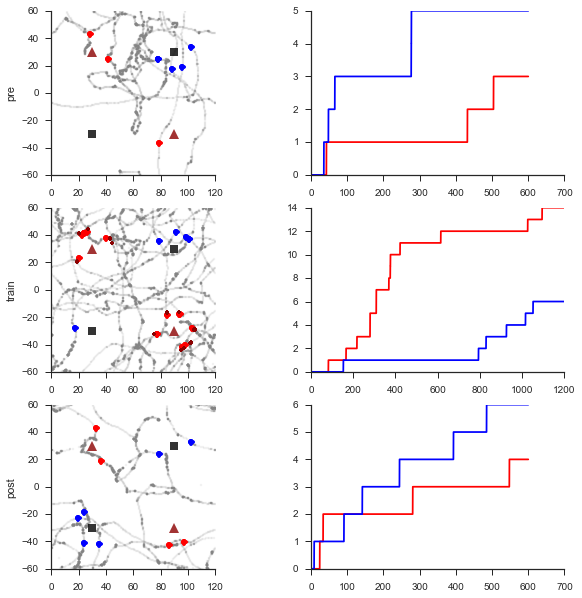

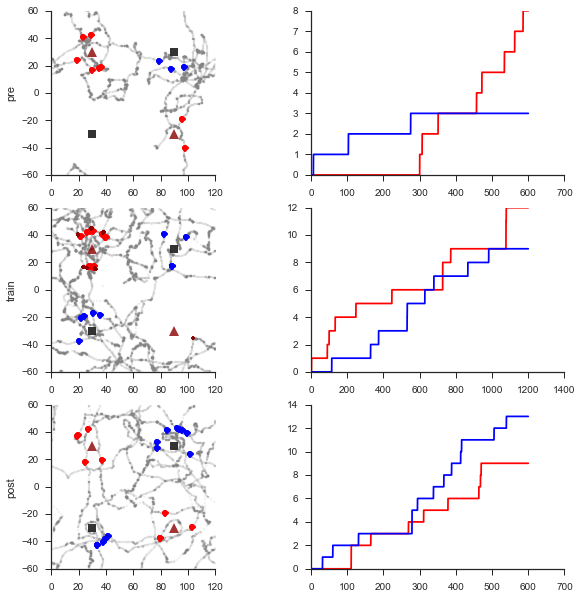

In [402]:
visitRad = 13

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

coneVisitFreq = np.zeros((len(flyIDs),len(trialName)))
cyliVisitFreq = np.zeros((len(flyIDs),len(trialName)))

coneVisitCount = np.zeros((len(flyIDs),len(trialName)))
cyliVisitCount = np.zeros((len(flyIDs),len(trialName)))

coneFirstVisit = np.zeros((len(flyIDs),len(trialName)))
cyliFirstVisit = np.zeros((len(flyIDs),len(trialName)))

coneVisitLength = np.zeros((len(flyIDs),len(trialName)))
cyliVisitLength = np.zeros((len(flyIDs),len(trialName)))


for fly in range(len(flyIDs)):
    visitFig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(len(trialName),2,width_ratios=[1,1])


    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()



        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)


        visitPlt = visitFig.add_subplot(gs[trial,0])
        visitPlt.plot(xPosTrial,yPosTrial,'.',color='grey',markersize=5,alpha=0.1)
        visitPlt.plot(xPosTrial[entriesCone>0],yPosTrial[entriesCone>0],'ro')
        visitPlt.plot(xPosTrial[entriesCyli>0],yPosTrial[entriesCyli>0],'bo')
        
        visitPlt.plot(xPosTrial[evTrial>0],yPosTrial[evTrial>0],'.',markersize=7,color='darkred')

        visitPlt.plot(cyliCoords[0][0], cyliCoords[0][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
        visitPlt.plot(coneCoords[0][0], coneCoords[0][1], marker='^', markersize=10, alpha=0.8, color=coneColor)
        visitPlt.plot(coneCoords[1][0], coneCoords[1][1], marker='^', markersize=10, alpha=0.8, color=coneColor)
        visitPlt.plot(cyliCoords[1][0], cyliCoords[1][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)

        visitPlt.set_aspect('equal')
        visitPlt.set_ylabel(trialtype)
        myAxisTheme(visitPlt)

        cumsumVisitPlt = visitFig.add_subplot(gs[trial,1])
        cumsumVisitPlt.plot(timeTrial,np.cumsum(entriesCone),'r')
        cumsumVisitPlt.plot(timeTrial,np.cumsum(entriesCyli),'b')
        myAxisTheme(cumsumVisitPlt)
        
        coneVisitFreq[fly,trial] = np.sum(entriesCone)/(timeTrial[-1]/60.0)
        cyliVisitFreq[fly,trial] = np.sum(entriesCyli)/(timeTrial[-1]/60.0)
        
        coneVisitCount[fly,trial] = np.sum(entriesCone)
        cyliVisitCount[fly,trial] = np.sum(entriesCyli)
        
        coneVisitLength[fly,trial] = np.sum(visitTCone)
        cyliVisitLength[fly,trial] = np.sum(visitTCyli)
        
        try:
            coneFirstVisit[fly,trial] = visitTCone[0]
        except:
            print('no cone visits detected')
            coneFirstVisit[fly,trial] = np.nan
        
        try:
            cyliFirstVisit[fly,trial] = visitTCyli[0]
        except:
            print('no cylinder visits detected')
            cyliFirstVisit[fly,trial] = np.nan


    try:
        mkdir(analysisDir + 'reinforcementEffect/')
    except:
        print('Plot directory already exists')
    visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_effectOnVisits_visitRad'+str(visitRad)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

Plot directory already exists


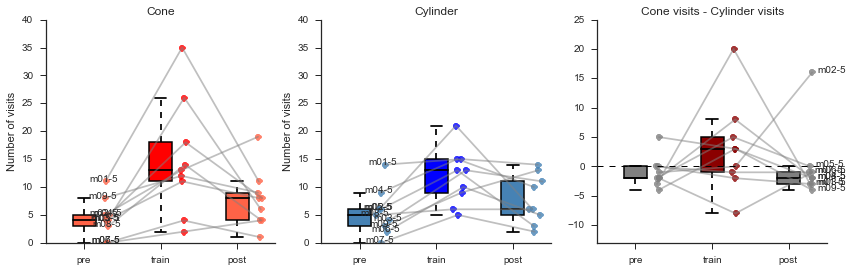

In [403]:
bpFig = plt.figure(figsize=(14,4))

objtypeNames = ['Cone','Cylinder']
BoxColors = [['tomato','red','tomato'],['steelblue','blue','steelblue']]
dotColors = ['black','green','black']
VisitCount = [coneVisitCount,cyliVisitCount]
offsets = [1.3, 1.3, 1.3]

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    bp = bpPlt.boxplot(VisitCount[objtype],patch_artist=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['medians'], color='black')
    plt.setp(bp['fliers'], color='black', marker='+')
    
    jitter = np.random.normal(0, 0.04, size=len(VisitCount[objtype][:,0]))
    for ind,box in enumerate(bp['boxes']):
        plt.setp(box, color='black', 
            linewidth=1.5, 
            facecolor=BoxColors[objtype][ind])
        
        # Add some random "jitter" to the x-axis
        x = ind+jitter+offsets[ind]
        bpPlt.plot(x, VisitCount[objtype][:,ind], 'o', color=BoxColors[objtype][ind], alpha=0.8)
    
    for fly in range(len(flyIDs)):
        bpPlt.text(-0.2+jitter[fly]+offsets[0], VisitCount[objtype][fly,0],flyIDs[fly])
        
        bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),2+jitter[fly]+offsets[2])),
                   VisitCount[objtype][fly,:], '-', color='grey', alpha=0.5)

    plt.xticks(range(1,len(trialName)+1),trialName)
    bpPlt.set_ylim((0,5+np.max(VisitCount)))
    bpPlt.set_ylabel('Number of visits')
    bpPlt.set_title(objtypeNames[objtype])
    myAxisTheme(bpPlt)

VisitCountRatio = coneVisitCount-cyliVisitCount
BoxColors = ['grey','darkred','grey']

bpPlt = bpFig.add_subplot(1,3,3)
bp = bpPlt.boxplot(VisitCountRatio,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

jitter = np.random.normal(0, 0.02, size=len(VisitCount[objtype][:,0]))
for ind,box in enumerate(bp['boxes']):
    plt.setp(box, color='black', 
        linewidth=1.5, 
        facecolor=BoxColors[ind])

    # Add some random "jitter" to the x-axis
    x = ind+jitter+offsets[ind]
    bpPlt.plot(x, VisitCountRatio[:,ind], 'o', color=BoxColors[ind], alpha=0.8)

for fly in range(len(flyIDs)):
    bpPlt.text(2.08+jitter[fly]+offsets[2], VisitCountRatio[fly,2],flyIDs[fly])
    bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),2+jitter[fly]+offsets[2])),
               VisitCountRatio[fly,:], '-', color='grey', alpha=0.5)

bpPlt.axhline(y=0, linewidth=1,color='black', linestyle='dashed')
plt.xticks(range(1,len(trialName)+1),trialName)
bpPlt.set_ylim((-5+np.min(VisitCountRatio),5+np.max(VisitCountRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')
myAxisTheme(bpPlt)

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

Plot directory already exists


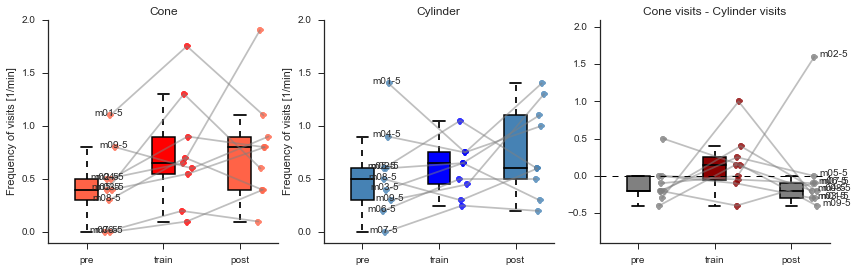

In [404]:
bpFig = plt.figure(figsize=(14,4))

objtypeNames = ['Cone','Cylinder']
BoxColors = [['tomato','red','tomato'],['steelblue','blue','steelblue']]
dotColors = ['black','green','black']
VisitCount = [coneVisitFreq,cyliVisitFreq]
offsets = [1.3, 1.3, 1.3]

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    bp = bpPlt.boxplot(VisitCount[objtype],patch_artist=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['medians'], color='black')
    plt.setp(bp['fliers'], color='black', marker='+')
    
    jitter = np.random.normal(0, 0.04, size=len(VisitCount[objtype][:,0]))
    for ind,box in enumerate(bp['boxes']):
        plt.setp(box, color='black', 
            linewidth=1.5, 
            facecolor=BoxColors[objtype][ind])
        
        # Add some random "jitter" to the x-axis
        x = ind+jitter+offsets[ind]
        bpPlt.plot(x, VisitCount[objtype][:,ind], 'o', color=BoxColors[objtype][ind], alpha=0.8)
    
    for fly in range(len(flyIDs)):
        bpPlt.text(-0.2+jitter[fly]+offsets[0], VisitCount[objtype][fly,0],flyIDs[fly])
        
        bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),2+jitter[fly]+offsets[2])),
                   VisitCount[objtype][fly,:], '-', color='grey', alpha=0.5)

    plt.xticks(range(1,len(trialName)+1),trialName)
    bpPlt.set_ylim((-0.1,.1+np.max(VisitCount)))
    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(objtypeNames[objtype])
    myAxisTheme(bpPlt)

VisitCountRatio = coneVisitFreq-cyliVisitFreq
BoxColors = ['grey','darkred','grey']

bpPlt = bpFig.add_subplot(1,3,3)
bp = bpPlt.boxplot(VisitCountRatio,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

jitter = np.random.normal(0, 0.02, size=len(VisitCount[objtype][:,0]))
for ind,box in enumerate(bp['boxes']):
    plt.setp(box, color='black', 
        linewidth=1.5, 
        facecolor=BoxColors[ind])

    # Add some random "jitter" to the x-axis
    x = ind+jitter+offsets[ind]
    bpPlt.plot(x, VisitCountRatio[:,ind], 'o', color=BoxColors[ind], alpha=0.8)

for fly in range(len(flyIDs)):
    bpPlt.text(2.08+jitter[fly]+offsets[2], VisitCountRatio[fly,2],flyIDs[fly])
    bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),2+jitter[fly]+offsets[2])),
               VisitCountRatio[fly,:], '-', color='grey', alpha=0.5)

plt.xticks(range(1,len(trialName)+1),trialName)
bpPlt.axhline(y=0, linewidth=1,color='black', linestyle='dashed')
bpPlt.set_ylim((-0.5+np.min(VisitCountRatio),0.5+np.max(VisitCountRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')
myAxisTheme(bpPlt)

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitFrequency_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

Plot directory already exists


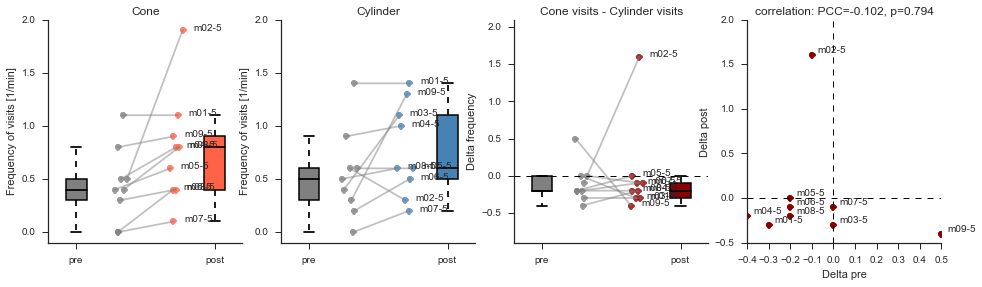

In [405]:
# compare just pre and post

bpFig = plt.figure(figsize=(16,4))

objtypeNames = ['Cone','Cylinder']
BoxColors = [['grey','tomato'],['grey','steelblue']]
VisitCount = [coneVisitFreq[:,[0,2]],cyliVisitFreq[:,[0,2]]]
offsets = [1.3, 0.7]

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    bp = bpPlt.boxplot(VisitCount[objtype],patch_artist=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['medians'], color='black')
    plt.setp(bp['fliers'], color='black', marker='+')
    
    jitter = np.random.normal(0, 0.03, size=len(VisitCount[objtype][:,0]))
    for ind,box in enumerate(bp['boxes']):
        plt.setp(box, color='black', 
            linewidth=1.5, 
            facecolor=BoxColors[objtype][ind])
        
        # Add some random "jitter" to the x-axis
        x = ind+jitter+offsets[ind]
        bpPlt.plot(x, VisitCount[objtype][:,ind], 'o', color=BoxColors[objtype][ind], alpha=0.8)
    
    for fly in range(len(flyIDs)):
        bpPlt.text(1.08+jitter[fly]+offsets[1], VisitCount[objtype][fly,1],flyIDs[fly])
        
        bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])))),
                   VisitCount[objtype][fly,:], '-', color='grey', alpha=0.5)

    plt.xticks(range(1,len(trialName)),[trialName[0],trialName[2]])
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylim((-0.1,.1+np.max(VisitCount)))
    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(objtypeNames[objtype])
    myAxisTheme(bpPlt)

VisitCountRatio = coneVisitFreq[:,[0,2]]-cyliVisitFreq[:,[0,2]]
BoxColors = ['grey','darkred']

bpPlt = bpFig.add_subplot(1,4,3)
bp = bpPlt.boxplot(VisitCountRatio,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

jitter = np.random.normal(0, 0.03, size=len(VisitCount[objtype][:,0]))
for ind,box in enumerate(bp['boxes']):
    plt.setp(box, color='black', 
        linewidth=1.5, 
        facecolor=BoxColors[ind])

    # Add some random "jitter" to the x-axis
    x = ind+jitter+offsets[ind]
    bpPlt.plot(x, VisitCountRatio[:,ind], 'o', color=BoxColors[ind], alpha=0.8)

for fly in range(len(flyIDs)):
    bpPlt.text(1.08+jitter[fly]+offsets[1], VisitCountRatio[fly,1],flyIDs[fly])
    bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])))),
               VisitCountRatio[fly,:], '-', color='grey', alpha=0.5)

plt.xticks(range(1,len(trialName)),[trialName[0],trialName[2]])
bpPlt.axhline(y=0, linewidth=1,color='black', linestyle='dashed')
bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.5+np.min(VisitCountRatio),0.5+np.max(VisitCountRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')
bpPlt.set_ylabel('Delta frequency')
myAxisTheme(bpPlt)

# correlation between pre and post prefererence 

bpPlt = bpFig.add_subplot(1,4,4)
bpPlt.plot(VisitCountRatio[:,0],VisitCountRatio[:,1],'o',color='darkred')
for fly in range(len(flyIDs)):
    bpPlt.text(VisitCountRatio[fly,0]+0.03,VisitCountRatio[fly,1]+0.03,flyIDs[fly])
    
from scipy.stats.stats import pearsonr
rsq, p = pearsonr(VisitCountRatio[:,0],VisitCountRatio[:,1])
bpPlt.set_xlabel('Delta pre')
bpPlt.set_ylabel('Delta post')
bpPlt.axhline(y=0, linewidth=1,color='black', linestyle='dashed')
bpPlt.axvline(x=0, linewidth=1,color='black', linestyle='dashed')
bpPlt.set_title('correlation: PCC='+str(round(rsq,3))+', p='+str(round(p,3)))
myAxisTheme(bpPlt)

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

Plot directory already exists


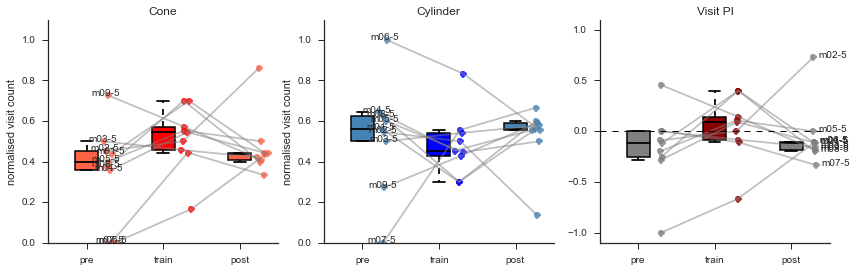

In [406]:
# Compute "PERFORMANCE INDEX" as [#cone - #cyli]/total #
bpFig = plt.figure(figsize=(14,4))

objtypeNames = ['Cone','Cylinder']
BoxColors = [['tomato','red','tomato'],['steelblue','blue','steelblue']]
dotColors = ['black','green','black']
VisitCount = [coneVisitCount,cyliVisitCount]
totalVisitCount = coneVisitCount+cyliVisitCount
totalVisitCount[np.where(totalVisitCount==0)] = np.nan
VisitCount = np.squeeze(VisitCount)/totalVisitCount
VisitCount[np.where(np.isnan(VisitCount))] = 0
offsets = [1.3, 1.3, 1.3]

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    bp = bpPlt.boxplot(VisitCount[objtype],patch_artist=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['medians'], color='black')
    plt.setp(bp['fliers'], color='black', marker='+')
    
    jitter = np.random.normal(0, 0.04, size=len(VisitCount[objtype][:,0]))
    for ind,box in enumerate(bp['boxes']):
        plt.setp(box, color='black', 
            linewidth=1.5, 
            facecolor=BoxColors[objtype][ind])
        
        # Add some random "jitter" to the x-axis
        x = ind+jitter+offsets[ind]
        bpPlt.plot(x, VisitCount[objtype][:,ind], 'o', color=BoxColors[objtype][ind], alpha=0.8)
    
    for fly in range(len(flyIDs)):
        bpPlt.text(-0.2+jitter[fly]+offsets[0], VisitCount[objtype][fly,0],flyIDs[fly])
        
        bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),2+jitter[fly]+offsets[2])),
                   VisitCount[objtype][fly,:], '-', color='grey', alpha=0.5)

    plt.xticks(range(1,len(trialName)+1),trialName)
    bpPlt.set_ylim((0,1.1))
    bpPlt.set_ylabel('normalised visit count')
    bpPlt.set_title(objtypeNames[objtype])
    myAxisTheme(bpPlt)

VisitCountRatio = np.squeeze(coneVisitCount-cyliVisitCount)/totalVisitCount
VisitCountRatio[np.where(np.isnan(VisitCountRatio))] = 0
BoxColors = ['grey','darkred','grey']

bpPlt = bpFig.add_subplot(1,3,3)
bp = bpPlt.boxplot(VisitCountRatio,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

jitter = np.random.normal(0, 0.02, size=len(VisitCount[objtype][:,0]))
for ind,box in enumerate(bp['boxes']):
    plt.setp(box, color='black', 
        linewidth=1.5, 
        facecolor=BoxColors[ind])

    # Add some random "jitter" to the x-axis
    x = ind+jitter+offsets[ind]
    bpPlt.plot(x, VisitCountRatio[:,ind], 'o', color=BoxColors[ind], alpha=0.8)

for fly in range(len(flyIDs)):
    bpPlt.text(2.08+jitter[fly]+offsets[2], VisitCountRatio[fly,2],flyIDs[fly])
    bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),2+jitter[fly]+offsets[2])),
               VisitCountRatio[fly,:], '-', color='grey', alpha=0.5)

plt.xticks(range(1,len(trialName)+1),trialName)
bpPlt.axhline(y=0, linewidth=1,color='black', linestyle='dashed')
bpPlt.set_ylim((-1.1,1.1))
bpPlt.set_title('Visit PI')
myAxisTheme(bpPlt)

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitPI_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

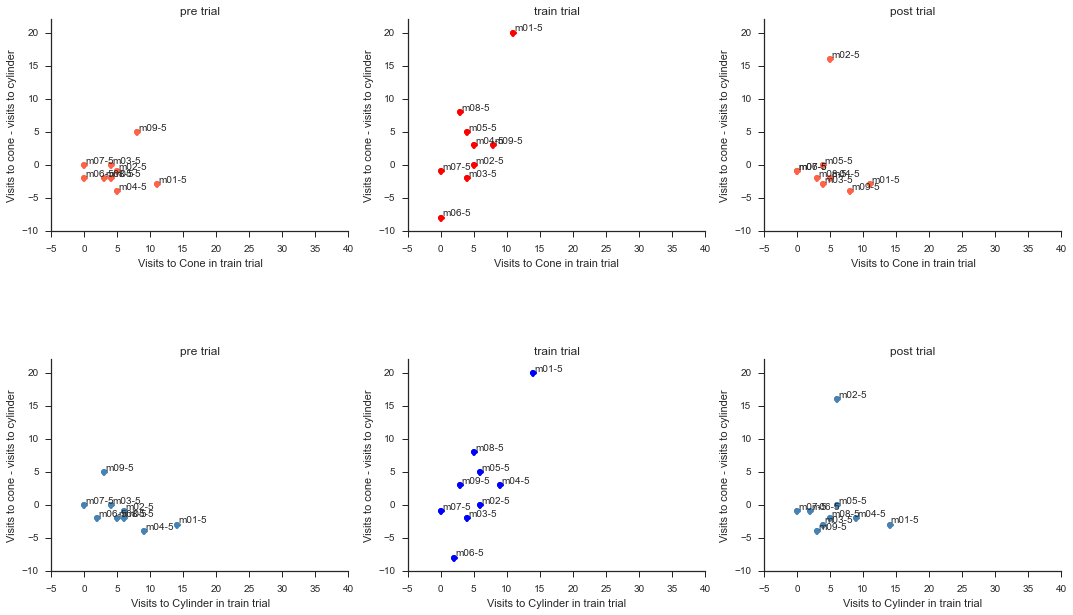

In [407]:
VisitCount = [coneVisitCount,cyliVisitCount]
VisitCountRatio = coneVisitCount-cyliVisitCount
trialColors = ['tomato','red','tomato']
             
objtype = 0 #0-cone 1-cylinder
corrFig = plt.figure(figsize=(15,10))
for trial in range(len(trialName)):
    for fly in range(len(flyIDs)):
        corrPlt = corrFig.add_subplot(2,len(trialName),trial+1)
        corrPlt.plot(VisitCount[objtype][fly,0],VisitCountRatio[fly,trial], 'o', color=trialColors[trial], alpha=1)
        corrPlt.text(VisitCount[objtype][fly,0]+0.3,VisitCountRatio[fly,trial]+0.3,flyIDs[fly])

    corrPlt.set_xlim(-5,np.max(VisitCount)+5)
    ylimmax = np.ceil(2+np.max((VisitCountRatio)))
    ylimmin = np.ceil(np.min((VisitCountRatio)))
    corrPlt.set_ylim(ylimmin-2,ylimmax)
    corrPlt.set_xlabel('Visits to '+objtypeNames[objtype]+' in train trial')
    corrPlt.set_ylabel('Visits to cone - visits to cylinder')
    corrPlt.set_title(trialName[trial]+' trial')
    corrPlt.set_aspect('equal')
    myAxisTheme(corrPlt)
      
objtype = 1 #0-cone 1-cylinder
trialColors = ['steelblue','blue','steelblue']
for trial in range(len(trialName)):
    for fly in range(len(flyIDs)):
        corrPlt = corrFig.add_subplot(2,len(trialName),len(trialName)+trial+1)
        corrPlt.plot(VisitCount[objtype][fly,0],VisitCountRatio[fly,trial], 'o', color=trialColors[trial], alpha=1)
        corrPlt.text(VisitCount[objtype][fly,0]+0.3,VisitCountRatio[fly,trial]+0.3,flyIDs[fly])

    corrPlt.set_xlim(-5,np.max(VisitCount)+5)
    ylimmax = np.ceil(2+np.max((VisitCountRatio)))
    ylimmin = np.ceil(np.min((VisitCountRatio)))
    corrPlt.set_ylim(ylimmin-2,ylimmax)
    corrPlt.set_xlabel('Visits to '+objtypeNames[objtype]+' in train trial')
    corrPlt.set_ylabel('Visits to cone - visits to cylinder')
    corrPlt.set_title(trialName[trial]+' trial')
    corrPlt.set_aspect('equal')
    myAxisTheme(corrPlt)

corrFig.tight_layout()
corrFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitCorrelation_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### Visit length

Plot directory already exists


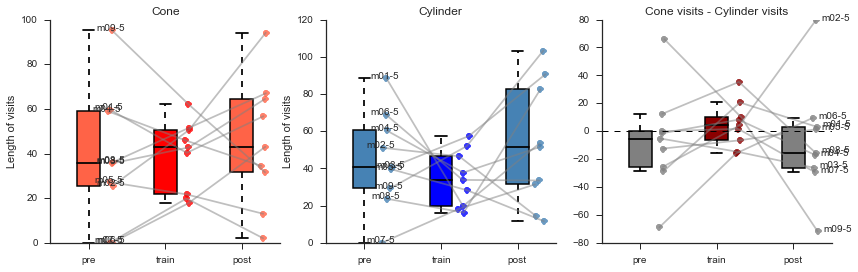

In [408]:
# Visit length

bpFig = plt.figure(figsize=(14,4))

objtypeNames = ['Cone','Cylinder']
BoxColors = [['tomato','red','tomato'],['steelblue','blue','steelblue']]
dotColors = ['black','green','black']
VisitCount = [coneVisitLength,cyliVisitLength]
offsets = [1.3, 1.3, 1.3]

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    bp = bpPlt.boxplot(VisitCount[objtype],patch_artist=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['medians'], color='black')
    plt.setp(bp['fliers'], color='black', marker='+')
    
    jitter = np.random.normal(0, 0.04, size=len(VisitCount[objtype][:,0]))
    for ind,box in enumerate(bp['boxes']):
        plt.setp(box, color='black', 
            linewidth=1.5, 
            facecolor=BoxColors[objtype][ind])
        
        # Add some random "jitter" to the x-axis
        x = ind+jitter+offsets[ind]
        bpPlt.plot(x, VisitCount[objtype][:,ind], 'o', color=BoxColors[objtype][ind], alpha=0.8)
    
    for fly in range(len(flyIDs)):
        bpPlt.text(-0.2+jitter[fly]+offsets[0], VisitCount[objtype][fly,0],flyIDs[fly])
        
        bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),2+jitter[fly]+offsets[2])),
                   VisitCount[objtype][fly,:], '-', color='grey', alpha=0.5)

    plt.xticks(range(1,len(trialName)+1),trialName)
    #bpPlt.set_ylim((0,np.max(VisitCount)))
    bpPlt.set_ylabel('Length of visits')
    bpPlt.set_title(objtypeNames[objtype])
    myAxisTheme(bpPlt)

VisitCountRatio = coneVisitLength-cyliVisitLength
BoxColors = ['grey','darkred','grey']

bpPlt = bpFig.add_subplot(1,3,3)
bp = bpPlt.boxplot(VisitCountRatio,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

jitter = np.random.normal(0, 0.03, size=len(VisitCount[objtype][:,0]))
for ind,box in enumerate(bp['boxes']):
    plt.setp(box, color='black', 
        linewidth=1.5, 
        facecolor=BoxColors[ind])

    # Add some random "jitter" to the x-axis
    x = ind+jitter+offsets[ind]
    bpPlt.plot(x, VisitCountRatio[:,ind], 'o', color=BoxColors[ind], alpha=0.8)

for fly in range(len(flyIDs)):
    bpPlt.text(2.08+jitter[fly]+offsets[2], VisitCountRatio[fly,2],flyIDs[fly])
    bpPlt.plot(np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),2+jitter[fly]+offsets[2])),
               VisitCountRatio[fly,:], '-', color='grey', alpha=0.5)

plt.xticks(range(1,len(trialName)+1),trialName)
bpPlt.axhline(y=0, linewidth=1,color='black', linestyle='dashed')
#bpPlt.set_ylim((-20,20))
bpPlt.set_title('Cone visits - Cylinder visits')
myAxisTheme(bpPlt)

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitLength_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

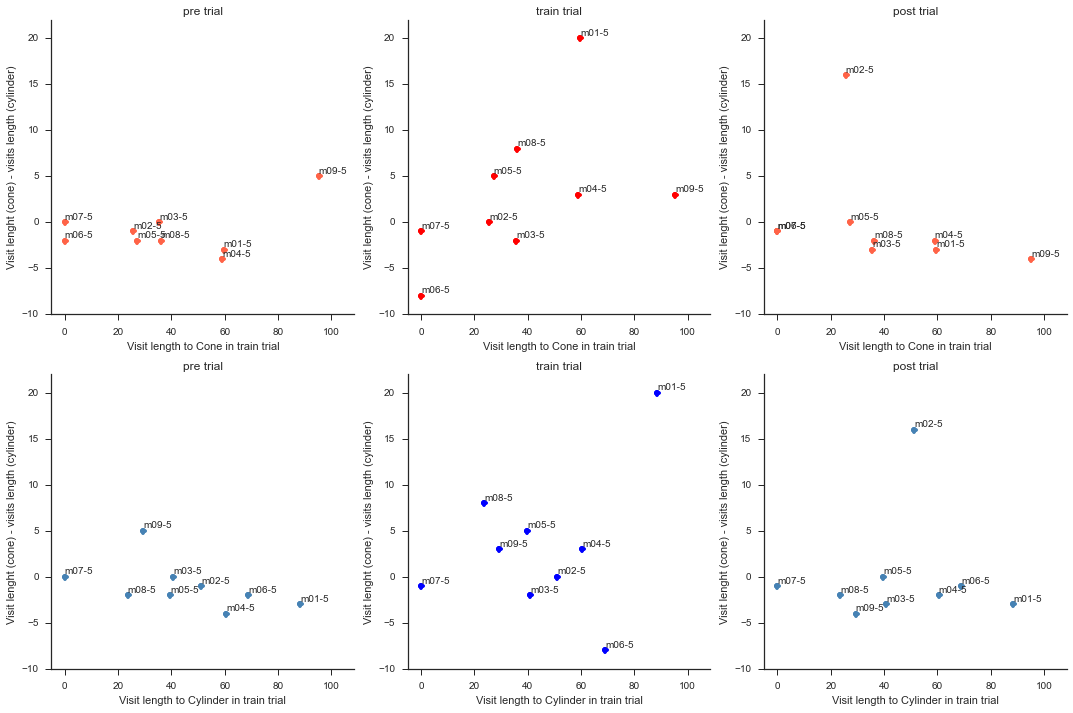

In [409]:
VisitCount = [coneVisitLength,cyliVisitLength]
VisitCountRatio = coneVisitCount-cyliVisitCount
trialColors = ['tomato','red','tomato']
             
objtype = 0 #0-cone 1-cylinder
corrFig = plt.figure(figsize=(15,10))
for trial in range(len(trialName)):
    for fly in range(len(flyIDs)):
        corrPlt = corrFig.add_subplot(2,len(trialName),trial+1)
        corrPlt.plot(VisitCount[objtype][fly,0],VisitCountRatio[fly,trial], 'o', color=trialColors[trial], alpha=1)
        corrPlt.text(VisitCount[objtype][fly,0]+0.3,VisitCountRatio[fly,trial]+0.3,flyIDs[fly])

    corrPlt.set_xlim(-5,np.max(VisitCount)+5)
    ylimmax = np.ceil(2+np.max((VisitCountRatio)))
    ylimmin = np.ceil(np.min((VisitCountRatio)))
    corrPlt.set_ylim(ylimmin-2,ylimmax)
    corrPlt.set_xlabel('Visit length to '+objtypeNames[objtype]+' in train trial')
    corrPlt.set_ylabel('Visit lenght (cone) - visits length (cylinder)')
    corrPlt.set_title(trialName[trial]+' trial')
    myAxisTheme(corrPlt)
    
objtype = 1 #0-cone 1-cylinder
trialColors = ['steelblue','blue','steelblue']
for trial in range(len(trialName)):
    for fly in range(len(flyIDs)):
        corrPlt = corrFig.add_subplot(2,len(trialName),len(trialName)+trial+1)
        corrPlt.plot(VisitCount[objtype][fly,0],VisitCountRatio[fly,trial], 'o', color=trialColors[trial], alpha=1)
        corrPlt.text(VisitCount[objtype][fly,0]+0.3,VisitCountRatio[fly,trial]+0.3,flyIDs[fly])

    corrPlt.set_xlim(-5,np.max(VisitCount)+5)
    ylimmax = np.ceil(2+np.max((VisitCountRatio)))
    ylimmin = np.ceil(np.min((VisitCountRatio)))
    corrPlt.set_ylim(ylimmin-2,ylimmax)
    corrPlt.set_xlabel('Visit length to '+objtypeNames[objtype]+' in train trial')
    corrPlt.set_ylabel('Visit lenght (cone) - visits length (cylinder)')
    corrPlt.set_title(trialName[trial]+' trial')
    myAxisTheme(corrPlt)

corrFig.tight_layout()
corrFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLengthCorrelation_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### Cumsum visit plot

Plot directory already exists


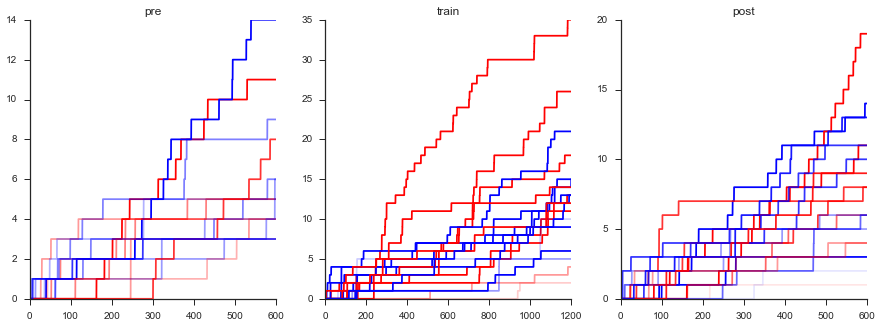

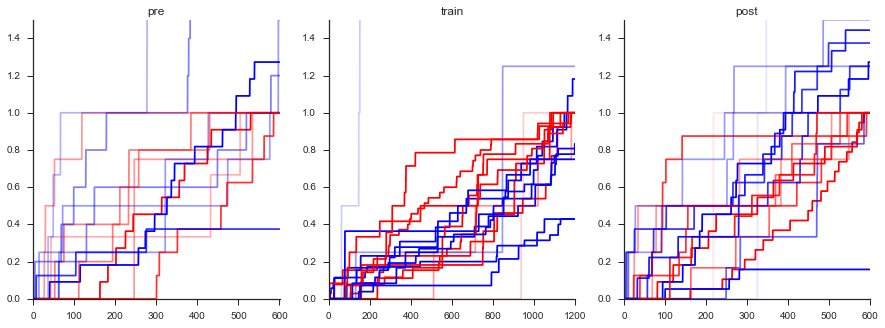

In [410]:
visitRad = 13

#visitFig = plt.figure(figsize=(10,10))
visitFig, cumsumVisitPlts = plt.subplots(1,len(trialName), figsize=(15,5))

scaledVisitFig, scaledCumsumVisitPlts = plt.subplots(1,len(trialName), figsize=(15,5))

vistitAlphaScale = [10,10,10]

for fly in range(len(flyIDs)):

    for trial in range(len(trialName)):
        trialtype = trialName[trial]
        
        #if(coneVisitCount[fly,0] <10):
        #    continue

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()


        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
            
        alphaVal = min(1.0,(sum(entriesCone)/vistitAlphaScale[trial]))

        cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone),'r', alpha = alphaVal)
        cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli),'b', alpha = alphaVal)
        cumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
        myAxisTheme(cumsumVisitPlts[trial])
        
        cumsumVisitPlts[trial].set_title(trialtype)
        
        scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone)/sum(entriesCone),'r', alpha = alphaVal)
        scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli)/sum(entriesCone),'b', alpha = alphaVal)
        scaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
        myAxisTheme(scaledCumsumVisitPlts[trial])
        
        scaledCumsumVisitPlts[trial].set_title(trialtype)
        scaledCumsumVisitPlts[trial].set_ylim(0,1.5)
        
        
try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')
scaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_coneScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

## Effect of repeated reward on movement

### Quantify the effect of the total amount of reward a fly experienced on movement patterns


In [411]:
rewardT = np.zeros(len(flyIDs))
vTrans = np.zeros((len(flyIDs),len(trialName)))
vRot = np.zeros((len(flyIDs),len(trialName)))

for fly in range(len(flyIDs)):
    querystring = '(trialtype=="train") & (flyID == "'+flyIDs[fly]+'")'
    evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()
    rewardT[fly] = np.sum(np.sign(evTrial))/fps
    
for fly in range(len(flyIDs)):
    for trial in range(3):
        querystring = '(trialtype=="'+trialName[trial]+'") & (flyID == "'+flyIDs[fly]+'")'
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
        perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
        perFlymov = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].values.squeeze()

        tSt = 0#(5*len(timeTrial))/10.0
        tEnd = len(timeTrial)
        vt = perFlyvT[tSt:tEnd]
        vr = perFlyvR[tSt:tEnd]
        mov = perFlymov.astype('bool')[tSt:tEnd] 
        vTrans[fly,trial] = np.squeeze(np.nanmedian(vt[mov]))
        vRot[fly,trial] = np.squeeze(np.nanmedian(abs(vr[mov])))

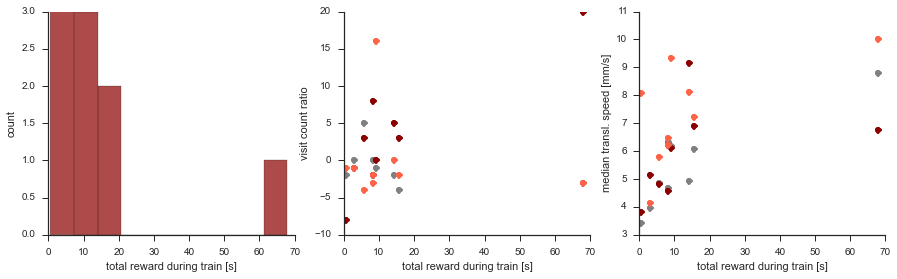

In [412]:
rewardExpFig, rewardExpPlts = plt.subplots(1,3, figsize=(15,4))

trialCols = ['grey','darkred','tomato']

rewardExpPlts[0].hist(rewardT,color=trialCols[1],alpha=0.7)
rewardExpPlts[0].set_xlabel('total reward during train [s]')
rewardExpPlts[0].set_ylabel('count')
myAxisTheme(rewardExpPlts[0])

for trial in range(3):
    VisitCountRatio = coneVisitCount[:,trial]-cyliVisitCount[:,trial]
    rewardExpPlts[1].plot(rewardT,VisitCountRatio,'o',color=trialCols[trial])
rewardExpPlts[1].set_xlabel('total reward during train [s]')
rewardExpPlts[1].set_ylabel('visit count ratio')
myAxisTheme(rewardExpPlts[1])

for trial in range(3):
    rewardExpPlts[2].plot(rewardT,vTrans[:,trial],'o',color=trialCols[trial])
rewardExpPlts[2].set_xlabel('total reward during train [s]')
rewardExpPlts[2].set_ylabel('median transl. speed [mm/s]')
myAxisTheme(rewardExpPlts[2])


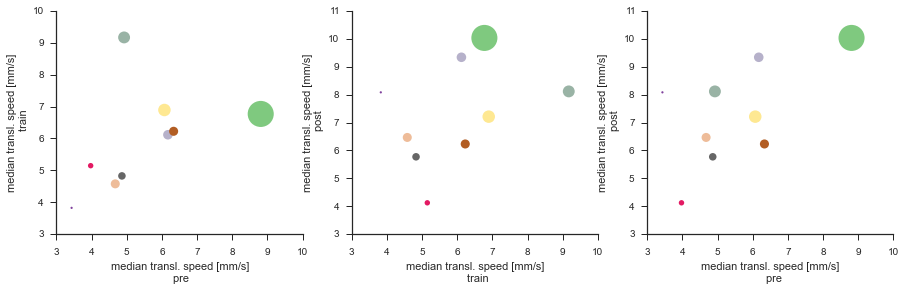

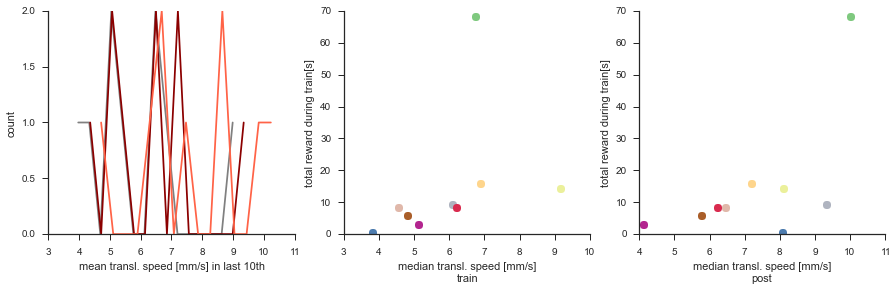

In [413]:
rewardExpFig, rewardExpPlts = plt.subplots(1,3, figsize=(15,4))

trialCols = ['grey','darkred','tomato']
sizefact = 10

rewardExpPlts[0].scatter(vTrans[:,0],vTrans[:,1],s=rewardT*sizefact,c=range(numFlies),cmap='Accent',edgecolor='none')
rewardExpPlts[0].set_xlabel('median transl. speed [mm/s]\n pre')
rewardExpPlts[0].set_ylabel('median transl. speed [mm/s]\n  train')
myAxisTheme(rewardExpPlts[0])

rewardExpPlts[1].scatter(vTrans[:,1],vTrans[:,2],s=rewardT*sizefact,c=range(numFlies),cmap='Accent',edgecolor='none')
rewardExpPlts[1].set_xlabel('median transl. speed [mm/s]\n  train')
rewardExpPlts[1].set_ylabel('median transl. speed [mm/s]\n  post')
myAxisTheme(rewardExpPlts[1])

rewardExpPlts[2].scatter(vTrans[:,0],vTrans[:,2],s=rewardT*sizefact,c=range(numFlies),cmap='Accent',edgecolor='none')
rewardExpPlts[2].set_xlabel('median transl. speed [mm/s]\n  pre')
rewardExpPlts[2].set_ylabel('median transl. speed [mm/s]\n  post')
myAxisTheme(rewardExpPlts[2])


rewardExpFig, rewardExpPlts = plt.subplots(1,3, figsize=(15,4))

trialCols = ['grey','darkred','tomato']
markerSize = 8

for trial in range(3):
    n,edges = np.histogram(vTrans[:,trial],bins=15)
    rewardExpPlts[0].plot(edges[1:]+np.mean(np.diff(edges))/2,n,color=trialCols[trial])
    rewardExpPlts[0].set_xlabel('mean transl. speed [mm/s] in last 10th')
    rewardExpPlts[0].set_ylabel('count')
    myAxisTheme(rewardExpPlts[0])
    
    if trial==0:
        continue
    
    for fly in range(len(flyIDs)):
        rewardExpPlts[trial].plot(vTrans[fly,trial],rewardT[fly],'o',markersize=markerSize,color=flyCMap.to_rgba(fly))
        rewardExpPlts[trial].set_xlabel('median transl. speed [mm/s]\n'+ trialName[trial])
        rewardExpPlts[trial].set_ylabel('total reward during train[s]')
        myAxisTheme(rewardExpPlts[trial])

In [414]:
from scipy.stats.stats import pearsonr
pearsonr(vTrans[:,0],vTrans[:,1])

(0.4518426299993164, 0.22208961299725563)

In [415]:
pearsonr(vTrans[:,1],vTrans[:,2])

(0.36502760329517303, 0.33407119628475196)

In [416]:
pearsonr(vTrans[:,0],vTrans[:,2])

(0.58922942448979376, 0.094994887848179582)

In [417]:
pearsonr(vTrans[:,1],rewardT)

(0.37705271898595139, 0.31715533213912755)

In [418]:
pearsonr(vTrans[:,2],rewardT)

(0.61450717333476923, 0.078266032652664783)

## Residency

### 2D (cartesian) residency

Plot directory already exists


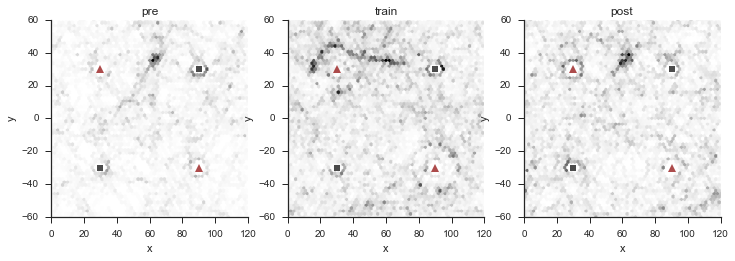

In [419]:
# plot parameter
numBins = 60

hexplotfig = plt.figure(figsize=(12,4))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys')
    plt.xlabel('x'); plt.ylabel('y')
    
    ax.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.7, color=cyliColor)
    ax.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.7, color=coneColor)
    ax.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.7, color=coneColor)
    ax.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.7, color=cyliColor)
            
    ax.set_title(trialName[trial])
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
    ax.set_aspect('equal')
    myAxisTheme(ax)
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### 1D (radial) residency

In [ ]:
#movementFilter = 'moving > 0'
#numBins = 30
#histRange = (5,arenaRad)
#
#radResFig = plt.figure(figsize=(7,5))
#radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
#radResPlt = radResFig.add_subplot(111)
#
#radResPlt = oneDimResidency_df(radResPlt, FOAllFlies_df, keyind_xPos, keyind_yPos, movementFilter,
#                               visibilityState, numBins, histRange,1)
#myAxisTheme(radResPlt)
#radResFig.tight_layout()
#
#try:
#    mkdir(analysisDir + 'residencyPlots/')
#except:
#    print('Plot directory already exists')
#radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
#                    + '_radialResidency_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### Generate frames for trace movie

In [12]:
import matplotlib.patches as patches

def plotBodyAngle(ax, x, y, angle, markerColor, alphaVal, arrowScale):
    #try:
    newArrow = patches.FancyArrow(x, y, np.cos(angle).squeeze()*arrowScale, np.sin(angle).squeeze()*arrowScale,
                                  width=0.25, head_width=0.25,
                                  edgecolor=markerColor, facecolor=markerColor, alpha=alphaVal)
    ax.add_patch(newArrow)
    #except:
    #    print("could not draw arrow")

In [13]:
visitRad = 13

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

cyliColor = 'darkblue'
coneColor = 'darkred'

        
fly=1
trial = 0

trialtype =trialName[trial]

querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
angleFly = FOAllFlies_df.query(querystring).iloc[:, keyind_ang:keyind_ang+1].values.squeeze()
timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

count=0

for frame in range(11*20*60,12*20*60):#int(len(timeTrial)*0.1)):
    frameName = str(frame)
    
    visitFig = plt.figure(figsize=(5,5))
    visitPlt = visitFig.add_subplot(111)
    
    xpos = xPosTrial[frame]
    ypos = yPosTrial[frame]
    
    # compute distance to each landmark
    dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
    dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
    dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
    dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

    # compute distance to closest landmark
    dist2closestCone = np.minimum(dist2cone1,dist2cone2)
    dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

    entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
    entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
    
    visitPlt.plot(xpos,ypos,'.',color='black',markersize=11,alpha=0.6)
    plotBodyAngle(visitPlt, xpos, ypos, angleFly[frame],'black', 0.6, 5)

    if(entriesCone[frame]>0):
        visitPlt.plot(xpos,ypos,'ro',markersize=10,)
    
    if(entriesCyli[frame]>0):
        visitPlt.plot(xpos,ypos,'bo',markersize=10)
        
    if(evTrial[frame]>0):
        visitPlt.plot(xpos,ypos,'.',markersize=14,color='darkred')

    visitPlt.plot(cyliCoords[0][0], cyliCoords[0][1], marker='s', markersize=11, alpha=0.8, color=cyliColor)
    visitPlt.plot(coneCoords[0][0], coneCoords[0][1], marker='^', markersize=14, alpha=0.8, color=coneColor)
    visitPlt.plot(coneCoords[1][0], coneCoords[1][1], marker='^', markersize=14, alpha=0.8, color=coneColor)
    visitPlt.plot(cyliCoords[1][0], cyliCoords[1][1], marker='s', markersize=11, alpha=0.8, color=cyliColor)

    visitPlt.set_xlim(0,120)
    visitPlt.set_ylim(-60,60)
    visitPlt.set_aspect('equal')
    
    visitPlt.set_title(trialtype)
    myAxisTheme(visitPlt)
    

    try:
        mkdir(analysisDir + 'movieMaterial/')
    except:
        count=count+1
        
    visitFig.savefig(analysisDir + 'movieMaterial/'+ genotype +'_'+flyIDs[0][0]
                       +'_collapsedTrace_fly'+ flyIDs[fly] +'_frame'+frameName.zfill(5)+'.png', format='png')
    
    
    plt.close("all")

### Velocity and relative heading distributions

In [ ]:
#for ttind,trialtype in enumerate(visibilityState):
#    
#    veloDistFig = plotVeloHeadingDistribution_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong, vTransTH)
#    veloDistFig.tight_layout()
#    
#    veloDistFig.savefig(analysisDir + 'velocityTraces/'+ genotype +'_'+flyIDs[0][0]+ '_' + trialtype + '_rZones' + rZoneState[ttind]
#                + '_veloDistributions_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

In [ ]:
#for ttind,trialtype in enumerate(visibilityState):
#    
#    veloDistFig = plotVeloHeadingDistribution2_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong, vTransTH)
#    veloDistFig.tight_layout()
#
#    veloDistFig.savefig(analysisDir + 'velocityTraces/'+ genotype +'_'+flyIDs[0][0]+ '_' + trialtype + '_rZones' + rZoneState[ttind]
#                + '_veloDistributions2_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')